# Лабораторная работа "Открытый оптический резонатор"

## В  настоящем блокноте представлена  программа для графического представления  полученны осциллограм в  случаях:
 ###              в режиме наилучшего согласования ООР и сканирующего интерферометра
###              в режиме умеренного согласования ООР и сканирующего интерферометра
###              в двухчастотномрежиме работы лазеры


In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, peak_widths
from scipy.signal import savgol_filter
import copy

In [4]:
# Пути для данных и сохранения результатов
data_path =  "E:\\учёба\\8 семестр\\Labs\\OOR_lab_data"
save_path = "results"


## Известные параметры

In [5]:
lamda = 632.8e-9  # длина волны лазера  
L_laser = 0.37    # длина резонатора лазера
c = 3e+8          # скорость света в вакууме 
R_interf = 1      # радиус кривизны сканирующего интерферометра 
L__interf = 0.05  # длина резонатора интерферометра

In [127]:
def unpack(path): 
    file = open(path, 'r' )
    data = file.readlines()
    data = [line.rstrip().split(",") for line in data]
    settings = data[:4]
    del data[:5]
    data = np.array(data).astype("float")
    return  settings, data

def unpack_two_ch(path, mode): 
    chanal = ["2","3"]
    source = ['gen' , "oor"]
    data = []
    for i in range(2):         
        file = open(path + "\\" + "Chanal_{}_{}_{}.txt".format(chanal[i], source[i], mode ), 'r' )
        signal = file.readlines()
        signal = [line.rstrip().split(",") for line in signal]
        if i == 0: 
            settings = signal[:4]
        del signal[:5]
        signal = np.array(signal).astype("float")
        data.append(signal)
    time = data[0][:,0]
    signal_oor = data[1][:,1]
    signal_gen = data[0][:,1]
    return  settings, time, signal_oor, signal_gen

def find_max(data, prominence, distance):
    max_ind = find_peaks(data[1],  prominence =  prominence, distance = distance)
    return [data[0][max_ind[0]],data[1][max_ind[0]], max_ind[0] ]

def calc_width(left_coords, right_coords, time_data):
         return time_data[right_coords] - time_data[left_coords]
    
def calc_arrow_params(left_half_max_ind, right_half_max_ind, half_level, left_steps, right_steps, time, arrow_head_part ):
    line_part = 1 - arrow_head_part
    left_arrow_start = time[left_half_max_ind - left_steps]  
    right_arrow_start = time[right_half_max_ind + right_steps] 
    left_arrow_length = (time[left_half_max_ind] - left_arrow_start) * line_part
    right_arrow_length = (
                            (right_arrow_start - time[right_half_max_ind]) - 
                            (arrow_head_part * (time[left_half_max_ind] - left_arrow_start))
                          )
    arrow_head_length = (time[left_half_max_ind] - left_arrow_start) * arrow_head_part
    tau_high = half_level.max() * 0.05 + half_level
    tau_time = time[right_half_max_ind + 80]
    res =   [
              left_arrow_start, 
              left_arrow_length,
              right_arrow_start,
              right_arrow_length, 
              time[left_half_max_ind],
              time[right_half_max_ind],
              arrow_head_length, 
              half_level, 
              tau_time,
              tau_high,
            ]
    return res

def calc_arrow_params_2(max_ind, time, max_level, arrow_head_procent, tau_step):
    arrow_params = []
    for i in range(len(max_ind ) - 1):
        arrow_high  = max_level[i] + max_level.max()  * 0.05
        arrow_center =(time[max_ind[i + 1]] + time[max_ind[i]]) / 2
        arrow_length =  (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent - 1) / 2 
        arrow_head_length = (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent) / 2 
        tau_time = time[max_ind[i]] + (arrow_center - time[max_ind[i]]) * tau_step 
        tau_high = max_level[i] + max_level.max()  * 0.06
        arrow_params.append([arrow_center, arrow_high, arrow_length, arrow_head_length, tau_time, tau_high ])
    return arrow_params

def calc_vlines_params(max_ind, time, max_level,  start=None):
    vlines_param = []
    for i in range(len(max_ind)):
        if i == 0:
            y_max = max_level[i] + max_level.max() * 0.1
        else:
            y_max = max_level[i - 1] + max_level.max() * 0.1
        if start is None:
            y_min = max_level[i]
        else:
            y_min = start
        time_coord = time[max_ind[i]]
        vlines_param.append([time_coord, y_min, y_max])
    return vlines_param
    
    

In [7]:
# указатели для импортирования данных 
mode = ["full_agreement", "moderate_agreement" "double_frequency"]

## Двухчастотный режим работы лазера 

Первой задачей является определение масштаба, ведь осциллограф дает зависимость сигнала от времени, а не  сигнала от частоты.
Чтобы правильно замерить разницу частот между соседними модами и область свободной дисперсии(ОСД) сканирующего интерферометра в случае режимов наилучшего и умеренного согласований, нам необходимо померить время между наибольшими пиками в двухчастотном режиме. Это время будет соответствовать ОСД резонатора ЛАЗЕРА ($\frac{c}{2 L_{laser}}$), а  эту величину мы  можем посчитать из данных, приведённых в условии.

In [8]:
AFD_laser = c / (2 * L_laser)

In [9]:
settings_dfreq, time_dfreq, signal_oor_dfreq, signal_gen_dfreq   = unpack_two_ch(data_path, "double_frequency_a")
time_dfreq = time_dfreq - time_dfreq[0]

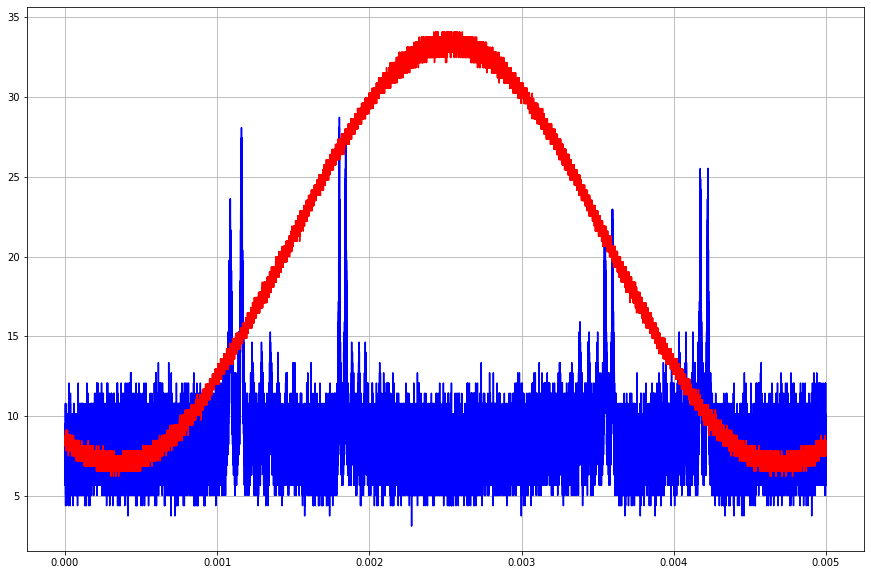

In [10]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq, signal_oor_dfreq*1000, c = 'blue') 
ax.plot(time_dfreq, signal_gen_dfreq+20, c = 'r')
ax.grid()

Отфильруем данные

In [11]:
signal_oor_dfreq_filtred = savgol_filter(signal_oor_dfreq, 99, 3)
signal_gen_dfreq_filtred = savgol_filter(signal_gen_dfreq, 99, 3)

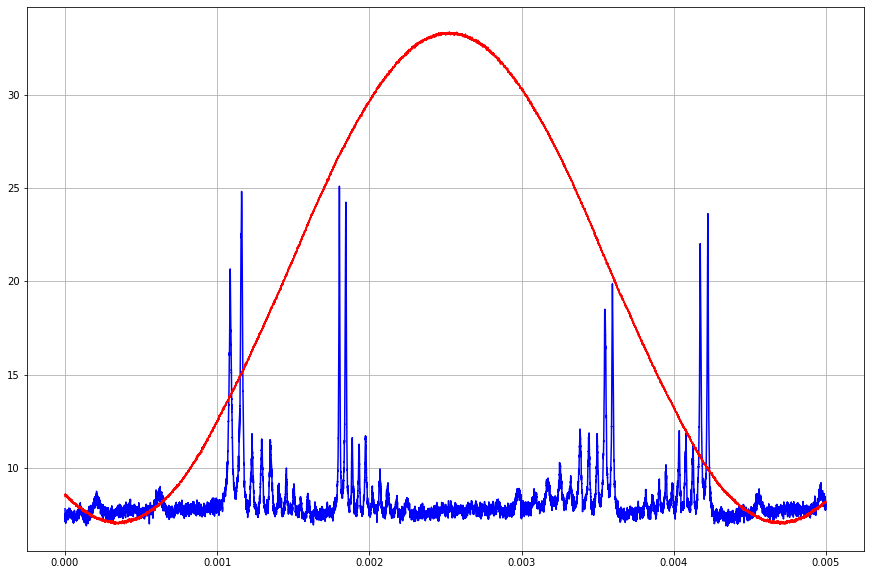

In [12]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq, signal_oor_dfreq_filtred*1000, c = 'blue') 
ax.plot(time_dfreq, signal_gen_dfreq_filtred + 20, c = 'r')
ax.grid()

Из оценочного графика видно., какой интервал подходит для определения ООД резонатора лазера лучше всего 


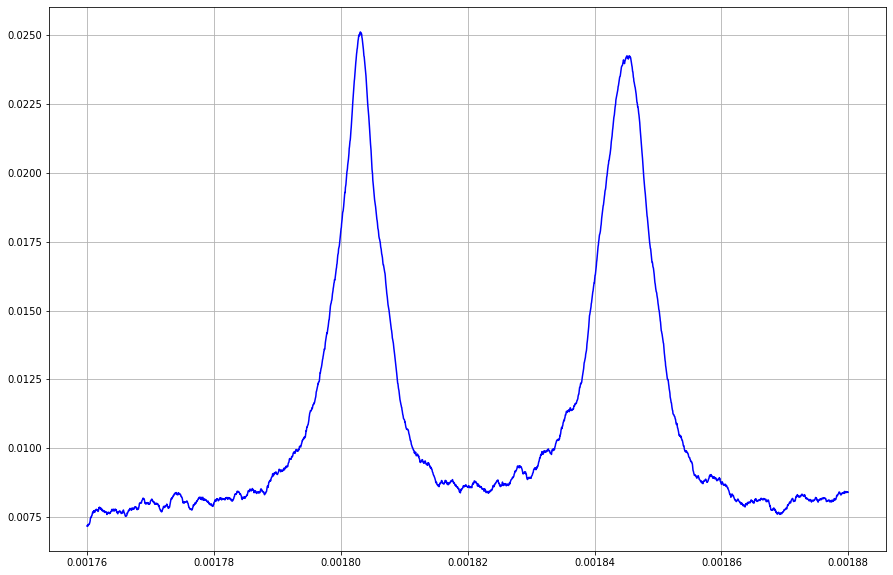

In [13]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq[44000:47000], signal_oor_dfreq_filtred[44000:47000], c = 'blue') 
ax.grid()

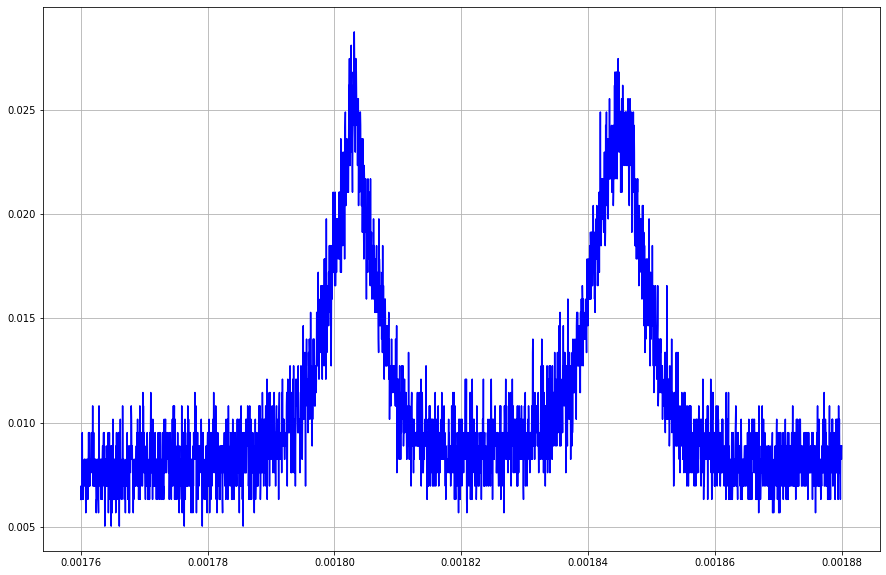

In [14]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq[44000:47000], signal_oor_dfreq[44000:47000], c = 'blue') 
ax.grid()

In [15]:
#переобозначим интересующую на зону
time_dfreq_crop = copy.copy(time_dfreq[44000:47000])
signal_oor_dfreq_crop = copy.copy(signal_oor_dfreq[44000:47000]) 
signal_oor_dfreq_filtred_crop = copy.copy(signal_oor_dfreq_filtred[44000:47000])
# сдвинем время на 0 и сигнал 
signal_oor_dfreq_crop = signal_oor_dfreq_crop - signal_oor_dfreq_crop.min()
signal_oor_dfreq_filtred_crop = signal_oor_dfreq_filtred_crop - signal_oor_dfreq_filtred_crop.min()
time_dfreq_crop = time_dfreq_crop - time_dfreq_crop[0]

In [16]:
max_time_dfreq_filtred_crop, max_signal_oor_dfreq_filtred_crop, max_ind_dfreq_filtred_crop = find_max([time_dfreq_crop,
                                                                                                       signal_oor_dfreq_filtred_crop
                                                                                                      ], 
                                                                                                      prominence = 0.01,
                                                                                                      distance = 500
                                                                                                         )

вычислим время, отвечающее ОСД

In [17]:
AFD_laser_time = max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]

Теперь определим коэффициент пересчета времени в частоту для того, чтобы определить частоту между соседними модами и ОСД сканирующего интерферометра в случае режимов наилучшего и умеренного согласований. 
Тогда выражение для разности частот примет вид: $ \Delta\nu = \Delta t  * \alpha = \frac{\Delta t  * c }{2 L_{laser} * AFD_{laser-time}}$ 

In [18]:
alpha = AFD_laser / AFD_laser_time
del_tau = AFD_laser_time
del_tau

4.204000000000013e-05

Оформим график  для отчета. Далее AFD_laser_time = $\Delta \tau$ на графике

In [19]:
#расчёт точек
time_coef = 1e+6
ampl_coef = 1e+3
line_width = 0.2*1e-3
max_line_width = max_signal_oor_dfreq_filtred_crop.max() * 1.1
arrow_centre = (max_time_dfreq_filtred_crop[1] + max_time_dfreq_filtred_crop[0]) / 2
arrow_high  =  max_signal_oor_dfreq_filtred_crop.max() * 1.05
arrow_length = (max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]) * 0.9 / 2 
arrow_head_width = line_width
arrow_head_length = (max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]) * 0.1 / 2 
tau_centre = (arrow_centre - (arrow_length + arrow_head_length)) * 1.35 
tau_high = arrow_high * 1.015


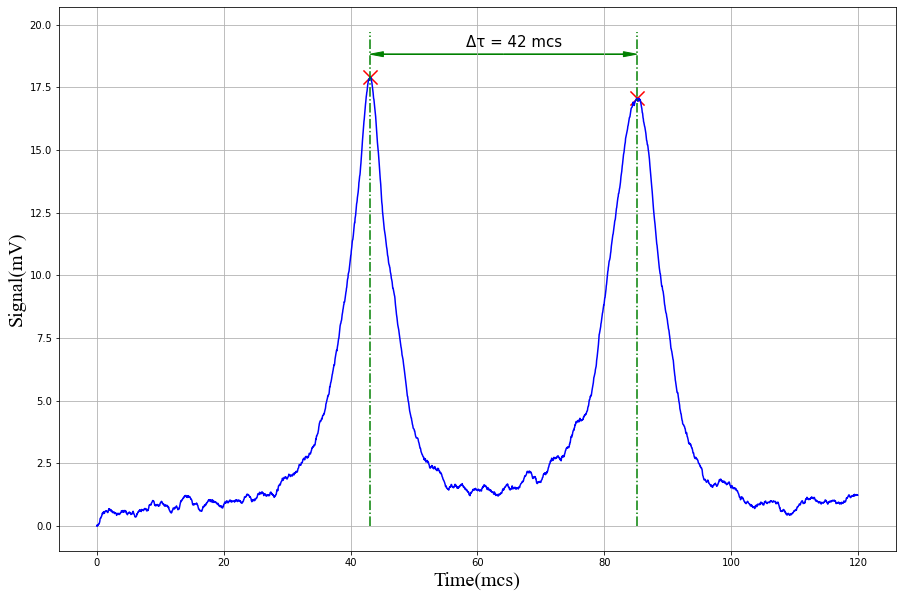

In [20]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq_crop * time_coef , signal_oor_dfreq_filtred_crop * ampl_coef , c = 'blue') 
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.text(tau_centre * time_coef, tau_high * ampl_coef, "Δτ = 42 mcs",fontsize = 15)
ax.scatter(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[0]] * time_coef,
            signal_oor_dfreq_filtred_crop[max_ind_dfreq_filtred_crop[0]] * ampl_coef,
            color='red', s=200, marker='x' 
            )
ax.scatter(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[1]] * time_coef,
            signal_oor_dfreq_filtred_crop[max_ind_dfreq_filtred_crop[1]] * ampl_coef,
            color='red', s=200, marker='x' 
            )
ax.vlines(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[0]]* time_coef,
            ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.vlines(
          time_dfreq_crop[max_ind_dfreq_filtred_crop[1]]* time_coef,
          ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.arrow(
         arrow_centre * time_coef, arrow_high * ampl_coef, -arrow_length  * time_coef, 0,
         head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g'
        )
ax.arrow(
          arrow_centre * time_coef, arrow_high * ampl_coef, arrow_length  * time_coef, 0,
          head_width=arrow_head_width* ampl_coef, head_length=arrow_head_length *time_coef , color = 'g'
        )
ax.grid()
plt.savefig(save_path + "\\" + "peacks_of_doble_freq_generation.jpg")


Когда коэффициент получен, можно определить все, что требуется по заданию 

## Режим наилучшего согласования ООР и сканирующего интерферометра

In [21]:
settings_full_agr, time_full_agr, signal_oor_full_agr, signal_gen_full_agr  = unpack_two_ch(data_path, "full_agreement")
# сдвинем для удобства время на 0
time_full_agr = time_full_agr - time_full_agr[0]

Отфильтруем сигнал

In [22]:
signal_oor_full_agr_filtred = savgol_filter(signal_oor_full_agr, 99, 3)

Находим  зону  информативного сигнала на первичном графике
Видно, что зона с индексами [24000:50000] вполне подходит

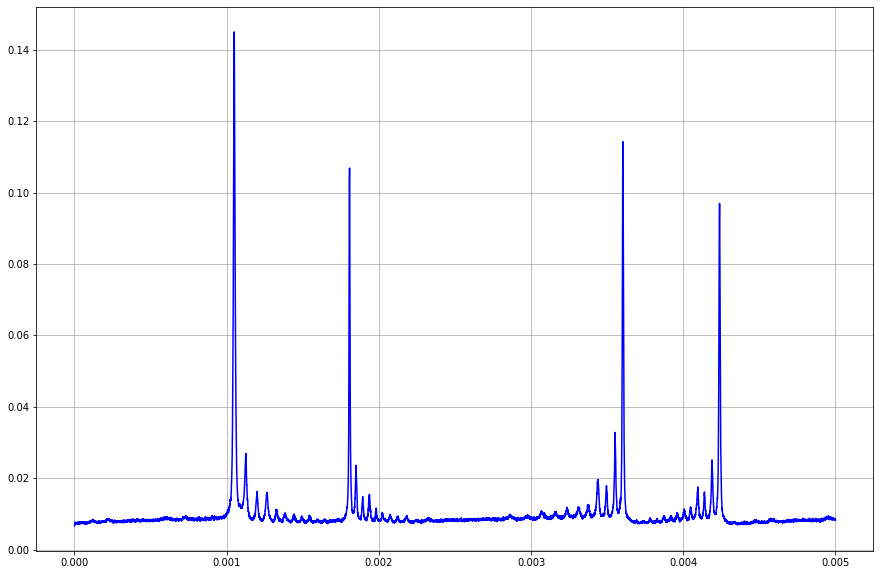

In [23]:
# первичный график
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr, signal_oor_full_agr_filtred, c = 'blue') 
ax.grid()


 Найдем расстояние между соседними поперечными модами 


In [24]:
time_full_agr_crop = copy.copy(time_full_agr[24000:50000])
time_full_agr_crop = time_full_agr_crop - time_full_agr_crop[0]
signal_oor_full_agr_filtred_crop = copy.copy(signal_oor_full_agr_filtred[24000:50000]) 
signal_oor_full_agr_filtred_crop = signal_oor_full_agr_filtred_crop - signal_oor_full_agr_filtred_crop.min()

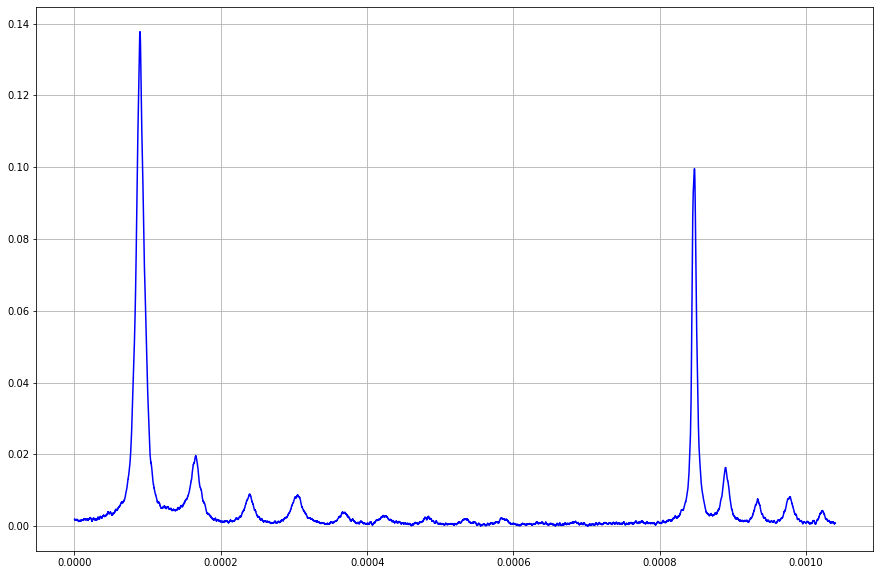

In [25]:
# первичный графи
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr_crop, signal_oor_full_agr_filtred_crop, c = 'blue') 
ax.grid()

Найдём максимумы

In [26]:
max_time_full_agr_filtred_crop, max_signal_oor_full_agr_filtred_crop, max_ind_full_agr_filtred_crop = find_max([time_full_agr_crop, signal_oor_full_agr_filtred_crop], 
                                                                                                                  prominence = 0.005,
                                                                                                                  distance = 500
                                                                                                                 )

Найдем ширины пиков

In [27]:
_, half_level_full_agr_crop, left_coord_indx_full_agr_crop, right_coord_indx_full_agr_crop = peak_widths(
                                                                                                            signal_oor_full_agr_filtred_crop, 
                                                                                                            max_ind_full_agr_filtred_crop, 
                                                                                                            rel_height=0.5 
                                                                                                            )

left_coord_indx_full_agr_crop = np.round(left_coord_indx_full_agr_crop).astype('int')
right_coord_indx_full_agr_crop = np.round(right_coord_indx_full_agr_crop).astype('int')


### Вычислим:
а) частотные интервалы между соседними
поперечными модами интерферометра;<br>
б) ширины резонансов для низших и высших
типов колебаний интерферометра

In [110]:
# частотные интервалы между соседними поперечными модами интерферометра
freq_interval_full_agr = np.diff(max_time_full_agr_filtred_crop) * alpha
freq_interval_full_agr = np.delete(freq_interval_full_agr, 3)
np.delete(np.diff(max_time_full_agr_filtred_crop),3)

array([7.616e-05, 7.364e-05, 6.576e-05, 4.228e-05, 4.428e-05, 4.440e-05])

In [109]:
# ширины резонансов для низших и высших типов колебаний интерферометра
peak_width_full_agr_crop = calc_width(left_coord_indx_full_agr_crop, right_coord_indx_full_agr_crop, time_full_agr_crop) * alpha

array([1.208e-05, 1.180e-05, 1.296e-05, 1.640e-05, 7.360e-06, 9.120e-06,
       9.200e-06, 1.164e-05])

In [30]:
# Область свободной дисперсии
AFD_full_agr = max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0]
AFD_full_agr * 1e+6 

757.84

### Нарисуем Графики 

In [35]:
time_coef = 1e+6
ampl_coef = 1e+3
line_width = 1e-3
max_line_width = max_signal_oor_full_agr_filtred_crop.max() * 1.1
arrow_centre = (max_time_full_agr_filtred_crop[4] + max_time_full_agr_filtred_crop[0]) / 2
arrow_high  =  max_signal_oor_full_agr_filtred_crop.max() * 1.05
arrow_length = (max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0]) * 0.9 / 2 
arrow_head_width = line_width
arrow_head_length = (max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0]) * 0.1 / 2 
tau_centre = (arrow_centre - (arrow_length + arrow_head_length)) * 4.35 
tau_high = arrow_high * 1.015

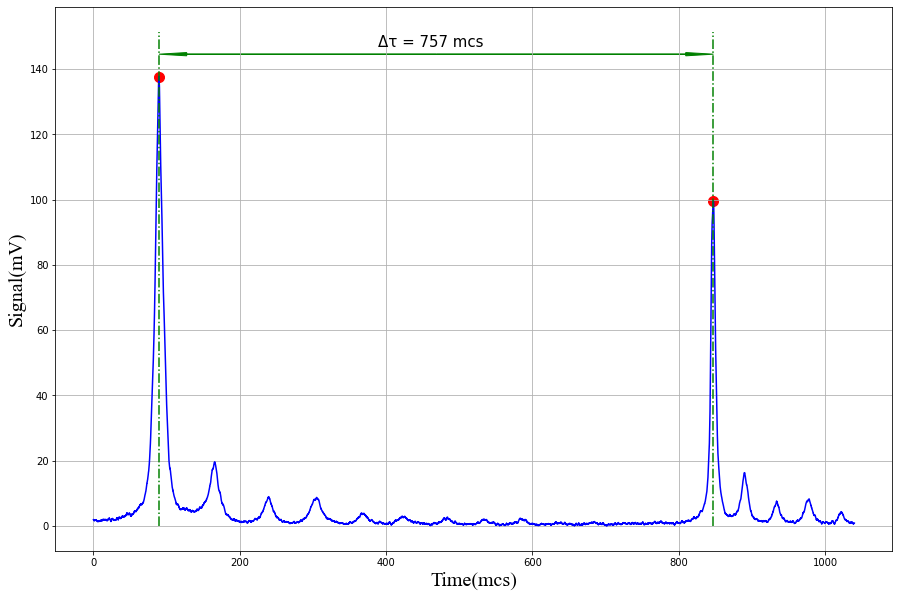

In [130]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr_crop * time_coef, signal_oor_full_agr_filtred_crop * ampl_coef , c = 'blue') 
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.text(tau_centre * time_coef, tau_high * ampl_coef, "Δτ = 757 mcs",fontsize = 15)
ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[0]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[0]] * ampl_coef,
            color='red', s=100, marker='o' 
            )
ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[4]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[4]] * ampl_coef,
            color='red', s=100, marker='o' 
            )
ax.vlines(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[0]]* time_coef,
            ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.vlines(
          time_full_agr_crop[max_ind_full_agr_filtred_crop[4]]* time_coef,
          ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.arrow(
         arrow_centre * time_coef, arrow_high * ampl_coef, -arrow_length  * time_coef, 0,
         head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g'
        )
ax.arrow(
          arrow_centre * time_coef, arrow_high * ampl_coef, arrow_length  * time_coef, 0,
          head_width=arrow_head_width* ampl_coef, head_length=arrow_head_length *time_coef , color = 'g'
        )
ax.grid()
plt.savefig(save_path + "\\" + "full_agr_AFD.jpg")

Нарисуем более детально 

In [131]:
time_coef = 1e+6
l_range = 0
r_range = 10000
ampl_coef = 1e+3
line_width = 1e-3
arrow_head_width = line_width
arrow_params = calc_arrow_params(
                                 left_coord_indx_full_agr_crop[:4], 
                                 right_coord_indx_full_agr_crop[:4],
                                 half_level_full_agr_crop[:4],
                                 300, 
                                 800, 
                                 time_full_agr_crop[l_range:r_range],
                                 0.5
                                )
arrow_params_2 = calc_arrow_params_2(max_ind=max_ind_full_agr_filtred_crop[:4] ,
                                     time=time_full_agr_crop, 
                                     max_level=max_signal_oor_full_agr_filtred_crop[:4], 
                                     arrow_head_procent=0.1, 
                                     tau_step = 0.7
                                     )

vlines_params = calc_vlines_params(max_ind=max_ind_full_agr_filtred_crop[:4] ,
                                   time=time_full_agr_crop,
                                   max_level=max_signal_oor_full_agr_filtred_crop[:4],
                                   start=0)


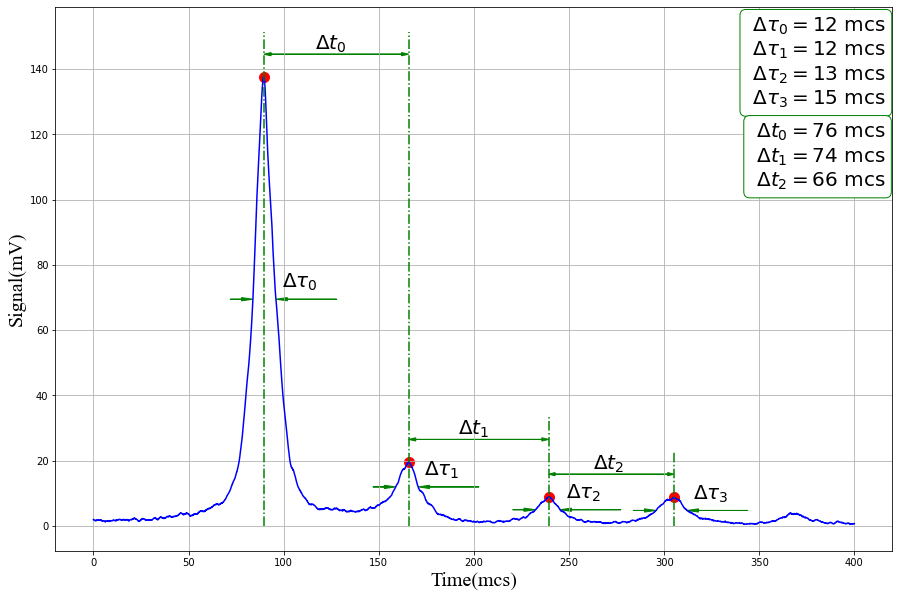

In [132]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(
        time_full_agr_crop[l_range:r_range] * time_coef, 
        signal_oor_full_agr_filtred_crop[l_range:r_range] * ampl_coef , c = 'blue'
        ) 

box = {'facecolor':'white',    
       'edgecolor': 'green',     
       'boxstyle': 'round'}

ax.text(343, 129, (' $Δτ_{0} = 12$ mcs\n $Δτ_{1} = 12$ mcs\n $Δτ_{2} = 13$ mcs\n $Δτ_{3} = 15$ mcs'),
        bbox = box,
        color = 'black',    
        fontsize = 20)

box = {'facecolor':'white',    
       'edgecolor': 'green',     
       'boxstyle': 'round'}

ax.text(345, 104, (' $Δt_{0} = 76$ mcs\n $Δt_{1} = 74$ mcs\n $Δt_{2} = 66$ mcs'),
        bbox = box,
        color = 'black',    
        fontsize = 20)
for i in range(4):
    ax.arrow(
             arrow_params[0][i] * time_coef,  arrow_params[7][i] * ampl_coef, + arrow_params[1][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'g'
            )
    ax.arrow(
             arrow_params[2][i] * time_coef,  arrow_params[7][i] * ampl_coef, -arrow_params[3][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'g'
            )
#     ax.hlines(
#             arrow_params[7][i] * ampl_coef, xmin = arrow_params[4][i] * time_coef, 
#             xmax = arrow_params[5][i] * time_coef, color = 'green'
#             )
    const = str(
                round((time_full_agr_crop[right_coord_indx_full_agr_crop[i]] - 
                time_full_agr_crop[left_coord_indx_full_agr_crop[i]] )* time_coef)
                )
    ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[i]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[i]] * ampl_coef,
            color='red', s=100, marker='o' 
            )
    
    ax.vlines(vlines_params[i][0] * time_coef, ymin = vlines_params[i][1] * ampl_coef, 
            ymax = vlines_params[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
            )
    ax.text(arrow_params[8][i] * time_coef, arrow_params[9][i] * ampl_coef, "$Δτ_{0}$".format(str(i)), fontsize = 20)
for i in range(3):
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, + arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, -arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    
    ax.text(arrow_params_2[i][4] * time_coef, arrow_params_2[i][5] * ampl_coef, "$Δt_{0}$".format(str(i)), fontsize = 20)
ax.grid()
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_agr_widths.jpg")
